In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

We are interested in modelling the displacement of the mass on a spring over time. For a detailed mathematical description of the harmonic oscillator, check out : https://beltoforion.de/en/harmonic_oscillator/.

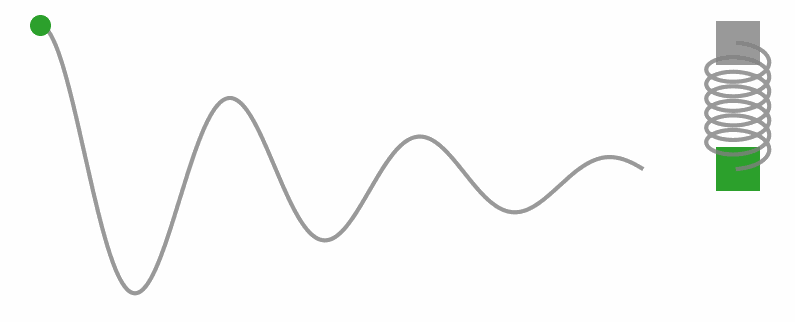

#1. Simulate the system using a PINN, given its initial conditions.

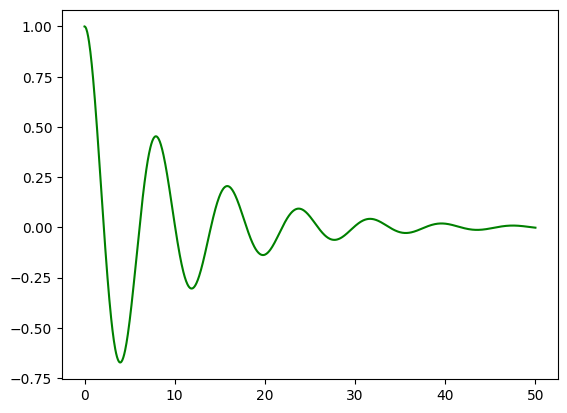

In [ ]:
def exact_solution(d,w0,t):
  """Defines the analytical solution to the PDE i.e. harmonic oscillator """
  assert w0 > d , "w0 is less than d"
  w = np.sqrt(w0**2 - d**2)
  phi = np.arctan(-d/w)
  A = 1/(2*np.cos(phi))
  cos = torch.cos(phi + w*t)
  exp = torch.exp(-d*t)
  u = exp*2*A*cos
  return u

#test
t = torch.linspace(0,50,1000)
y = exact_solution(0.1,0.8,t)
plt.plot(t,y,color = "green")

In [149]:
class FCN(nn.Module):
  "initializes a fully connected network"
  def __init__(self,n_input,n_output,n_hidden,n_layers):
    super().__init__()

    activation = nn.Tanh

    self.fcn = nn.Sequential(*[
        nn.Linear(n_input,n_hidden),
        activation()] )

    self.fch = nn.Sequential(*[
        nn.Sequential(*[
            nn.Linear(n_hidden,n_hidden),
            activation()]) for i in range(n_layers -1)
        ])

    self.fce = nn.Linear(n_hidden,n_output)

  def forward(self,x):
    x = self.fcn(x)
    x = self.fch(x)
    x = self.fce(x)

    return x

model = FCN(1,1,64,4)
print(model)

FCN(
  (fcn): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): Tanh()
  )
  (fch): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
    )
    (2): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
    )
  )
  (fce): Linear(in_features=64, out_features=1, bias=True)
)


Text(0.5, 1.0, 'Exact solution of PDE using test data')

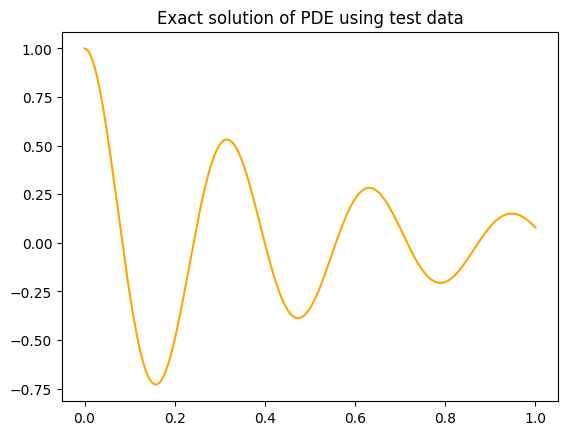

In [154]:
torch.manual_seed(123)

#boundry points
t_boundary = torch.tensor(0.).reshape(-1,1).requires_grad_(True) #shape [1,1]

#input or training data
t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True) #shape [30,1]

#test data
t_test = torch.linspace(0,1,300).view(-1,1) #shape [300,1]

#pde constants
d, w0 = 2,20
mu,k = 2*d,w0**2
u_exact = exact_solution(d,w0,t_test)
plt.plot(t_test,u_exact,color = "orange")
plt.title("Exact solution of PDE using test data")

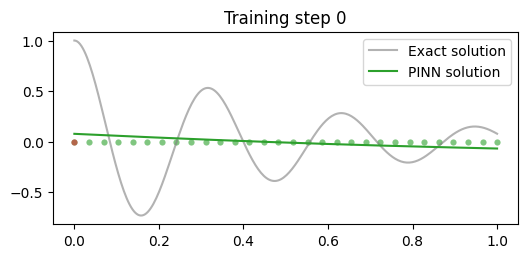

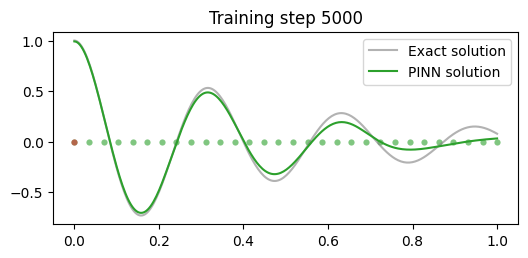

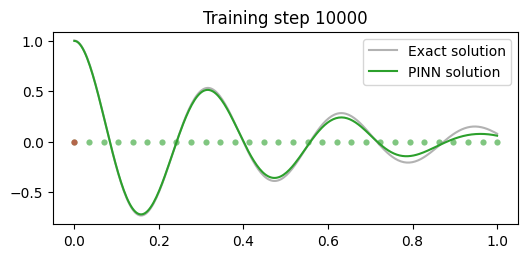

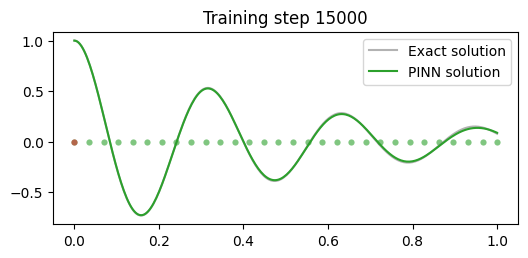

In [156]:
#initializing pinn i.e. u(t) using fully connected neural network
pinn = FCN(1,1,32,3)
optimizer = torch.optim.Adam(pinn.parameters(),lr = 1e-3)

#training
numepochs = 15001
loss_iterations = np.zeros([numepochs,4])

for i in range(numepochs):

  optimizer.zero_grad()
  lambda1, lambda2 = 1e-1,1e-4

  #boundary loss
  u = pinn(t_boundary)
  dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]# (1, 1) ##https://docs.pytorch.org/docs/stable/generated/torch.autograd.grad.html
  loss1 = (torch.squeeze(u)-1)**2
  loss2 = (torch.squeeze(dudt)-0)**2

  #physics loss
  u = pinn(t_physics) #[30,1]
  dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0] #[30,1]
  d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0] #[30,1]
  loss3 = torch.mean((d2udt2 + mu*dudt + k*u)**2)

  #total loss
  loss = loss1 + lambda1*loss2 + lambda2*loss3
  loss_iterations[i,0] = loss1
  loss_iterations[i,1] = loss2
  loss_iterations[i,2] = loss3
  loss_iterations[i,3] = loss

  loss.backward()
  optimizer.step()

    # plot the result as training progresses
  if i % 5000 == 0:
        #print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
        u = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach()[:,0],
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0],
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

[8.70584358e-07 6.72173542e-07 5.02657366e+00 5.03595162e-04]


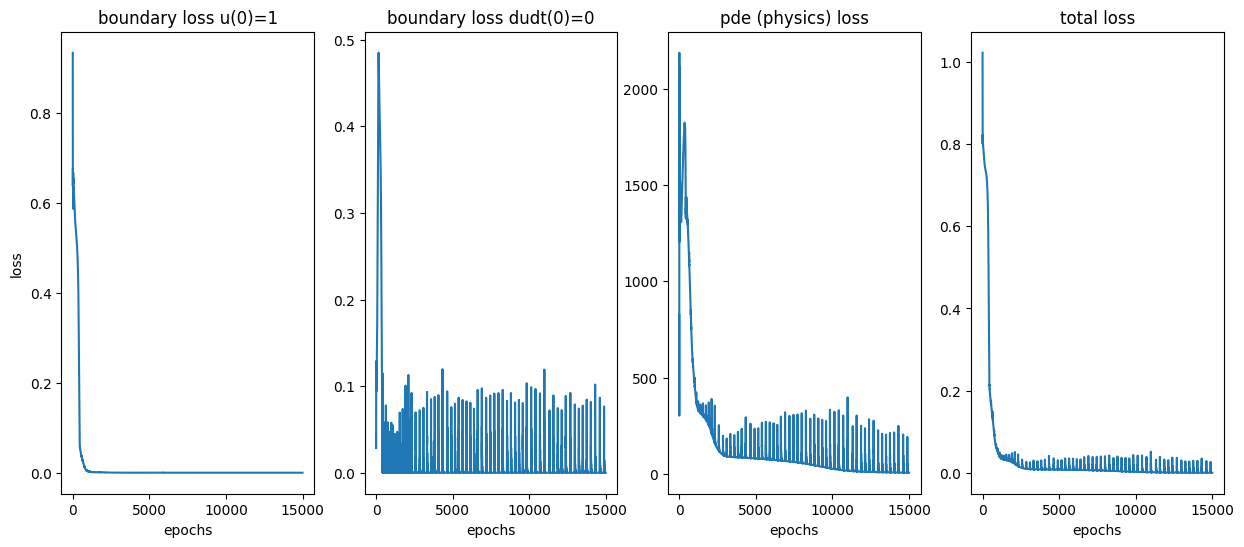

In [158]:
#visualize loss
fig,ax = plt.subplots(1,4,figsize = (15,6))

ax[0].plot(loss_iterations[:,0])
ax[0].set_xlabel("epochs")
ax[0].set_ylabel("loss")
ax[0].set_title("boundary loss u(0)=1")

ax[1].plot(loss_iterations[:,1])
ax[1].set_xlabel("epochs")
#ax[1].set_ylabel("loss")
ax[1].set_title("boundary loss dudt(0)=0")

ax[2].plot(loss_iterations[:,2])
ax[2].set_xlabel("epochs")
#ax[2].set_ylabel("loss")
ax[2].set_title("pde (physics) loss")

ax[3].plot(loss_iterations[:,3])
ax[3].set_xlabel("epochs")
#ax[3].set_ylabel("loss")
ax[3].set_title("total loss")

print(loss_iterations[-1,:])

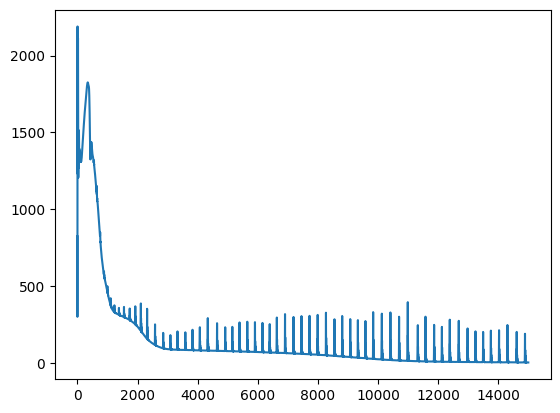

In [159]:
plt.plot(loss_iterations[:,2])

#2. Inverse problem

True value of mu: 4


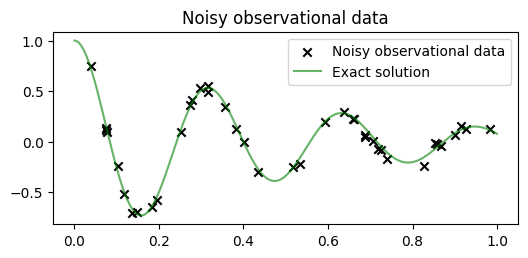

In [172]:
#noisy observational data
torch.manual_seed(123)
d, w0 = 2, 20
print(f"True value of mu: {2*d}")
t_obs = torch.rand(40).view(-1,1)
u_obs = exact_solution(d, w0, t_obs) + 0.04*torch.randn_like(t_obs)
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)

plt.figure(figsize=(6,2.5))
plt.title("Noisy observational data")
plt.scatter(t_obs[:,0], u_obs[:,0],label="Noisy observational data",marker = "x",color = 'black')
plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="green", alpha=0.6)
plt.legend()
plt.show()

<>:56: SyntaxWarning: invalid escape sequence '\m'
<>:56: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-660753512.py:56: SyntaxWarning: invalid escape sequence '\m'
  plt.title("$\mu$")


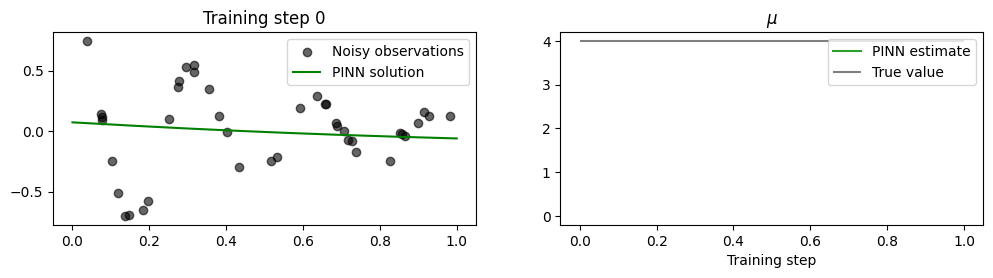

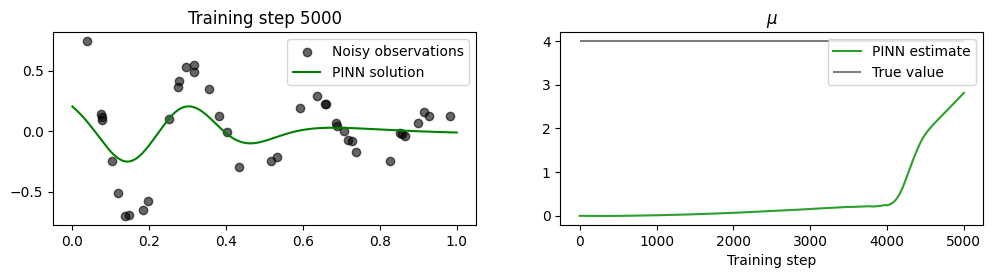

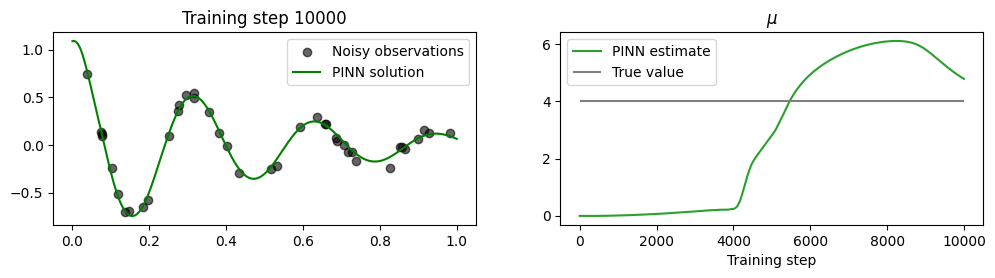

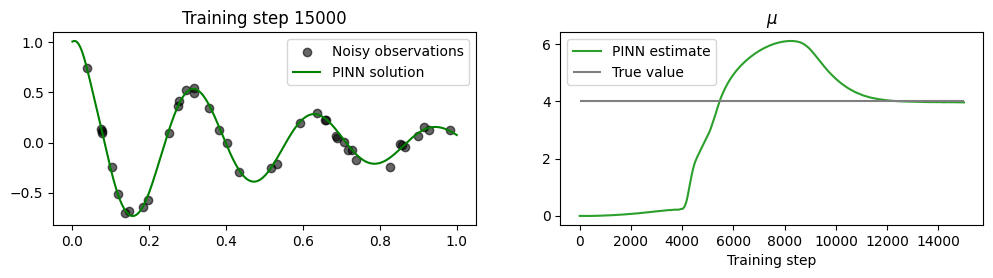

In [175]:
torch.manual_seed(123)

# define a neural network to train
pinn = FCN(1,1,32,3)

# define training points over the entire domain, for the physics loss
t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)# (30, 1)

# train the PINN
d, w0 = 2, 20
_, k = 2*d, w0**2
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)

# treat mu as a learnable parameter, add it to optimiser
mu = torch.nn.Parameter(torch.zeros(1, requires_grad=True))
optimiser = torch.optim.Adam(list(pinn.parameters())+[mu],lr=1e-3)
mus = []
for i in range(15001):
    optimiser.zero_grad()

    # compute each term of the PINN loss function above
    # using the following hyperparameters
    lambda1 = 1e4

    # compute physics loss
    u = pinn(t_physics)# (30, 1)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]# (30, 1)
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]# (30, 1)
    loss1 = torch.mean((d2udt2 + mu*dudt + k*u)**2)

    # compute data loss
    u = pinn(t_obs)
    loss2 = torch.mean((u - u_obs)**2)

    # backpropagate joint loss, take optimiser step
    loss = loss1 + lambda1*loss2
    loss.backward()
    optimiser.step()

    # record mu value
    mus.append(mu.item())

    # plot the result as training progresses
    if i % 5000 == 0:
        u = pinn(t_test).detach()
        plt.figure(figsize=(12,2.5))

        plt.subplot(1,2,1)
        plt.scatter(t_obs[:,0], u_obs[:,0], label="Noisy observations", alpha=0.6, color="black")
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="green")
        plt.title(f"Training step {i}")
        plt.legend()

        plt.subplot(1,2,2)
        plt.title("$\mu$")
        plt.plot(mus, label="PINN estimate", color="tab:green")
        plt.hlines(2*d, 0, len(mus), label="True value", color="tab:grey")
        plt.xlabel("Training step")
        plt.legend()

        plt.show()